In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from scipy.interpolate import RectBivariateSpline
from IPython.display import HTML

import tt
from tt.cross.rectcross import cross

In [2]:
# SDE parameters | dx = Ax dt + dW

A = np.array([
    [1.0, 0.0],
    [1.0, 1.0],
])

In [3]:
# Time grid

t_min = 0.
t_max = 1.
t_poi = 100

h = (t_max - t_min) / (t_poi - 1)
T = np.linspace(t_min, t_max, t_poi)

In [6]:
# Spatial grid

x_min = -3.
x_max = +3.
x_poi = 10

l = (x_max - x_min) / (x_poi - 1)

X = np.linspace(x_min, x_max, x_poi)
X1, X2 = np.meshgrid(X, X)
X = np.array([X1, X2])
X = X.reshape((2, -1))
# np.vstack((X1__.flatten(), X2__.flatten()))
X = X.T # TODO! Check

In [ ]:
# Initial condition for x



In [7]:
# Initial condition for r

def r_fun(i):
    x = x_min + l*i    
    # r = np.einsum('ik,ik->k', x.T, x.T)
    r = np.diag(x@x.T)
    return r

r0 = tt.rand(x_poi, 2, r=2)
r0 = cross(r_fun, x0, eps=1e-5, nswp=6, kickrank=1, rf=2) 

swp: 0/5 er_rel = 1.0e+00 er_abs = 3.1e+05 erank = 4.0 fun_eval: 1200
swp: 1/5 er_rel = 3.8e-16 er_abs = 1.2e-10 erank = 6.0 fun_eval: 3200


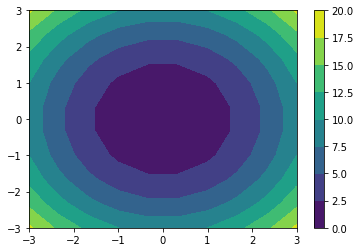

In [10]:
def evaluate_approximant(ten, x):
    n = 256
    # Evaluate piecewise-linear interpolant 
    nx = x.shape[0] # Number of points
    core_list = ten.to_list(ten) # To fix it later, stupid syntax
    core_vec = []
    h = (x_max - x_min) / (x_poi - 1)
    for i in range(x0.d):
        j = np.array((x[:, i] - x_min)/h, dtype=np.int)
        j[j<0] = 0
        j[j>=n-1] = n-2 
        xleft = x_min + j*h
        xright = x_min + (j+1)*h
        alpha = (xright - x[:, i])/h
        core_loc = np.einsum('k,ikj -> kij', alpha, core_list[i][:, j, :])  +  np.einsum('k,ikj -> kij', 1-alpha, core_list[i][:, j+1, :])
        core_vec.append(core_loc)

    mat = np.ones((nx, 1, 1))
    for cr in core_vec:
        mat = np.einsum('kij,kjl->kil', mat, cr)
    mat = np.squeeze(mat)
    return mat

res = evaluate_approximant(x0, X).reshape((x_poi, x_poi))
plt.contourf(X1, X2, res)
plt.colorbar()

In [11]:
nsteps = 1
def compute_value2(x0, tau, nsteps, nsamples, rho_prev):
    x = np.copy(x0)
    K = x.shape[1]
    x = np.repeat(x.reshape((d, -1)), nsamples, axis=1)
    #log_eta = np.zeros(x.shape[1])
    eta = np.ones(x.shape[1])
    for _ in range(nsteps):
        eta = eta * compute_trace(x, tau)
        x =  x + tau*A@x + np.sqrt(tau)*np.random.randn(*x.shape)*noise #Note +before A #Can replace with much better quadrature in the 
        #stochastic noise
    #w = np.exp(-logrho0(x))*eta
    val = evaluate_approximant(rho_prev, x.T)
    val = np.exp(-val)
    w = val*eta
    w = np.reshape(w, (K, nsamples))
    res = np.mean(w, axis=1)
    res = -np.log(res)
    return res

In [ ]:
sol = init.copy()

def my_fun2(ind):
    x = amin + h_grid*ind
    res = compute_value2(x.T, tau, nsteps, nsamples, sol)
    return res

nsamples = 100
tau = 8e-3
tm = 0.0
for _ in range(5):
    tm = tm + tau*nsteps
    sol1 = cross(my_fun2, sol, eps=1e-5, nswp=6, kickrank=1, rf=1.1)
    sol1 = sol1.round(1e-2)
    print((sol1-sol).norm()/sol.norm(), tm)

    sol = sol1.copy()

In [ ]:
M = 128
t = np.linspace(amin, amax, M)
X, Y = np.meshgrid(t, t)
Xall = np.vstack((X.flatten(), Y.flatten())).T
res = evaluate_approximant(sol, Xall).reshape((M, M))
print(np.sum(np.exp(-res)))
plt.contourf(t, t, np.exp(-res))
plt.colorbar()

In [5]:
# Initial condition

x0 = X.copy()
r0 = np.exp(-0.5 * np.diag(x0.T@x0))

In [6]:
def step(x0, r0):
    f = A@x0 # f(x, t)
    g = A    # d f(x, t) / dx
    E = 1.   # \int r_{\eta} d \eta = 1
    e = np.random.randn(*x0.shape)
    x = x0 + h * f + np.sqrt(h) * e
    r = E * r0 * (1. - h * np.trace(g))
    
    # TODO!
    # r_fnc = RectBivariateSpline(x0[0, :], x0[1, :], r)
    # r = r_fnc(*x, grid=False)
    
    return (x, r)

In [7]:
def calc():
    x = x0.copy()
    r = r0.copy()

    X_list = [x]
    R_list = [r]
    
    for _ in range(t_poi-1):
        x, r = step(x, r)
        X_list.append(x)
        R_list.append(r)
    
    return (X_list, R_list)

In [8]:
# Run caclulations

X_list, R_list = calc()

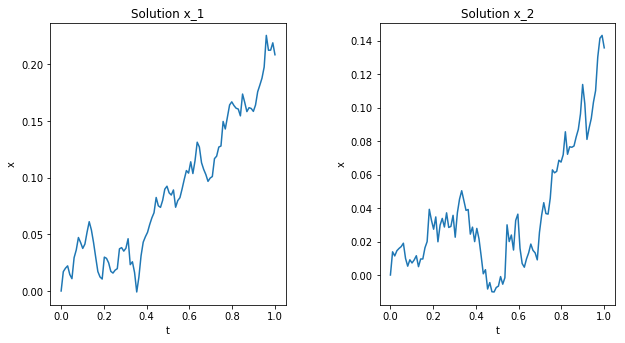

In [9]:
# Plot solution x

fig = plt.figure(figsize=(8, 4))
gs = mpl.gridspec.GridSpec(
    ncols=2, nrows=1, left=0.01, right=0.99, top=0.99, bottom=0.01,
    wspace=0.4, hspace=0.3, width_ratios=[1, 1], height_ratios=[1]
)

ax = fig.add_subplot(gs[0, 0])
ax.plot(T, [np.mean(X[0, :]) for X in X_list], label='x_1')
ax.set_title('Solution x_1')
ax.set_xlabel('t')
ax.set_ylabel('x')

ax = fig.add_subplot(gs[0, 1])
ax.plot(T, [np.mean(X[1, :]) for X in X_list], label='x_2')
ax.set_title('Solution x_2')
ax.set_xlabel('t')
ax.set_ylabel('x')

plt.show()

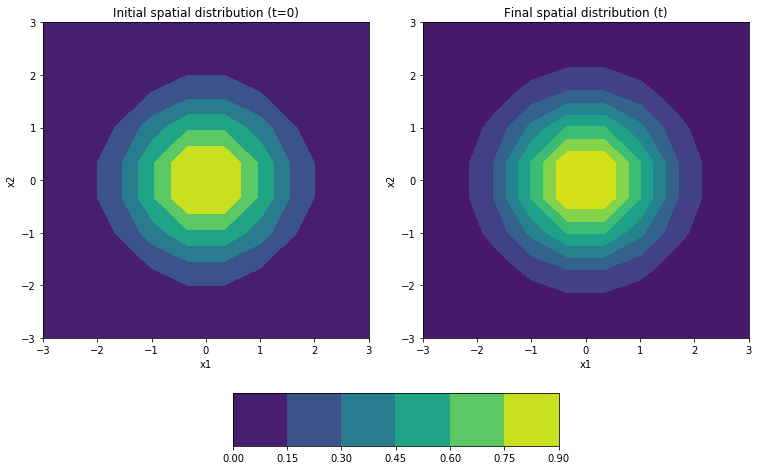

In [10]:
# Plot distribution (initial and final) on spatial grid

fig = plt.figure(figsize=(10, 6))
gs = mpl.gridspec.GridSpec(
    ncols=4, nrows=2, left=0.01, right=0.99, top=0.99, bottom=0.01,
    wspace=0.4, hspace=0.3, width_ratios=[1, 1, 1, 1], height_ratios=[6, 1]
)

ax = fig.add_subplot(gs[0, :2])
ct1 = ax.contourf(X1, X2, R_list[0].reshape((x_poi, x_poi)))
ax.set_title('Initial spatial distribution (t=0)')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

ax = fig.add_subplot(gs[0, 2:])
ct2 = ax.contourf(X1, X2, R_list[-1].reshape((x_poi, x_poi)))
ax.set_title('Final spatial distribution (t)')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

ax = fig.add_subplot(gs[1, 1:3])
cb = plt.colorbar(ct1, cax=ax, orientation='horizontal')
# cb.add_lines(ct2)

plt.show()

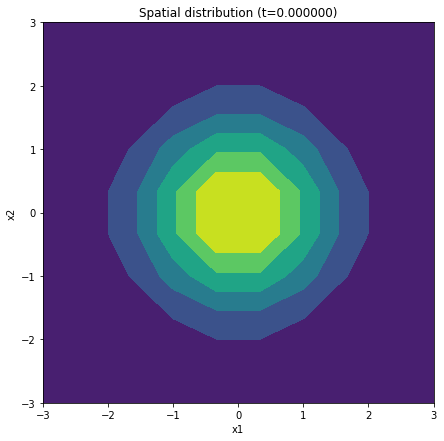

In [11]:
# Build animation for distribution

# Interval between frames
delt = 200 

# Path to ffmpeg executable
plt.rcParams['animation.ffmpeg_path'] = './../tmp/ffmpeg'

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

def run(i):
    t = T[i]
    r = R_list[i].reshape((x_poi, x_poi))

    ax.clear()
    ax.set_title('Spatial distribution (t=%f)'%t)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ct = ax.contourf(X1, X2, r)
    return (ct,)

anim = animation.FuncAnimation(fig, run, frames=len(T), interval=delt, blit=False)
HTML(anim.to_html5_video())